In [27]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 1. Importing  Data

In [28]:
list1 = pd.read_csv('listings.csv')
list2 = pd.read_csv('listings2.csv')
nbhd = pd.read_csv('neighbourhoods.csv')
calendar = pd.read_csv('calendar.csv')
review1 = pd.read_csv('reviews.csv')
review2 = pd.read_csv('reviews2.csv')
amenities = pd.read_csv('Cata Feature CSV/amenities.csv')
Integrate = pd.read_csv('Cata Feature CSV/IntegrateCata.csv')
amenities.shape
property_type = pd.read_csv('property_type.csv')
property_type.shape

(3818, 16)

#  2. Data Exploratory Analysis

In [29]:
# print(list1.columns.values)
# print(list1.shape)

In [30]:
# print(list2.columns.values)
# print(list2.shape)

In [31]:
# Join list1 and list2 to create the x vector
X = pd.concat([list1, list2], axis=1)
# print(X.shape)
# X.info(verbose = True, null_counts = True)

In [32]:
# X=X[X['property_type'].notnull()]
# X['property_type'].unique()
# # Increasing the feature space
# i=0
# for item in X['property_type'].unique():
#     a=X['property_type'] == X['property_type'].unique()[i]
#     X[item] = a.map(lambda x: 1 if x == True else 0)
#     i=i+1
# X.shape

In [33]:
Z1=X.loc[:, X.dtypes == np.float64] #Extracting columns with values of type float 
Z2=X.loc[:, X.dtypes == np.int64]   #Extracting columns with values of type int
Z3=X.loc[:, X.dtypes == np.object]   #Extracting columns with values of type categorical
X_numeric=pd.concat([Z1,Z2], axis=1)
X_cat = Z3
X_numeric.shape
# X_numeric.head()

(3818, 40)

In [34]:
"""X_numeric has duplicate columns. The code below removes the duplicate columns"""
_, i = np.unique(X_numeric.columns, return_index=True)
X_Num_Cov=X_numeric.iloc[:, i]
X_Num_Cov.to_csv('Numerical_FS.csv')

In [35]:
_, i = np.unique(X_cat.columns, return_index=True)
X_cat=X_cat.iloc[:, i]
# print(X_cat.describe())
# print(X_cat.info())
X_cat.to_csv('Catgorical_FS.csv')

# Creating X and Y for the dataset

In [36]:
X_select = X_Num_Cov[['reviews_per_month','accommodates','bathrooms','bedrooms','beds','guests_included','latitude','longitude','price']]
X_select['avail'] = list2[['availability_365']]
X_select = pd.concat([X_select, amenities, Integrate, property_type], axis=1)
X_select = X_select.dropna()
Y = X_select['reviews_per_month']
X_select = X_select.drop(['reviews_per_month','Unnamed: 0'], axis = 1)
# print(X_select.info())
# X_select.columns
# X_select.info(verbose = True, null_counts = True)


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
X_select.shape

(3173, 229)

# Splitting data into training and testing sets

In [38]:
num_test = 0.1
X_train, X_test, y_train, y_test = train_test_split(X_select, Y, test_size=num_test, random_state=23)
X_train.shape
y_train = y_train.to_frame()
y_test = y_test.to_frame()
print(X_train[['price']].head())
print(X_train.price[0])
y_train.reviews_per_month[0]

# X_test.shape
# property_type.head()

      price
1274    165
765     120
625      45
1828     28
448      95
85


4.0700000000000003

# Learning Curve

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Ridge Regression with Validation Curve

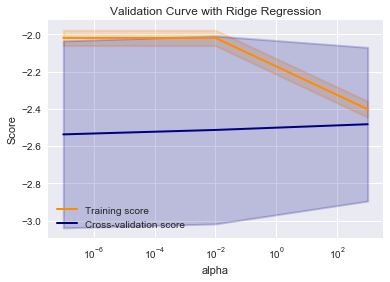

In [20]:
# clf = Ridge(alpha=1.0)
# clf.fit(X_train, y_train) 
# Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#       normalize=True, random_state=None, solver='auto', tol=0.001)
# ridgeTrain = clf.predict(X_train)
# ridgeTest = clf.predict(X_test)
# print(clf.score(X_test, y_test))
# r2_score( y_test,ridgeTest)



param_range = np.logspace(-7, 3, 3)
# train_scores, test_scores = validation_curve(
#     Ridge(), X_select, Y, param_name="alpha", param_range=param_range,
#     cv=10, scoring="accuracy", n_jobs=1)
train_scores, test_scores = validation_curve(Ridge(), X_select, Y, "alpha",param_range,cv=10, scoring="neg_mean_squared_error",n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("Score")
# plt.ylim(0.0, 5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Linear Regression

0.283033865097


<module 'matplotlib.pyplot' from '/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

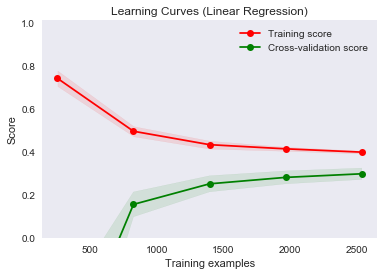

In [40]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))
regr.get_params()
regr.coef_

title = "Learning Curves (Linear Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
estimator = regr
plot_learning_curve(estimator, title, X_select, Y, (0, 1.01), cv=cv, n_jobs=4)

# Lasso

In [25]:
clf = linear_model.Lasso(alpha=0.0, fit_intercept=True, 
                         normalize=True, precompute=False, copy_X=True, 
                         positive=False, random_state=None,tol=0.001)
clf.fit(X_train, y_train) 
print(clf.score(X_test, y_test))

# param_range = np.logspace(-7, 3, 3)
# # train_scores, test_scores = validation_curve(
# #     Ridge(), X_select, Y, param_name="alpha", param_range=param_range,
# #     cv=10, scoring="accuracy", n_jobs=1)
# train_scores, test_scores = validation_curve(Lasso(), X_select, Y, "alpha",param_range,cv=10, n_jobs=1)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.title("Validation Curve with Lasso Regression")
# plt.xlabel("alpha")
# plt.ylabel("Score")
# plt.ylim(0.0, 0.5)
# lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
# plt.legend(loc="best")
# plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


0.283064620715


/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
#            max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
#            oob_score=False, random_state=0, verbose=0, warm_start=False)
clf = RandomForestRegressor(max_depth=20, random_state=0)
clf.fit(X_train, y_train)
# print(clf.feature_importances_)
RFTrain = clf.predict(X_train)
RFTest = clf.predict(X_test)
clf.score(X_test, y_test)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.37513253992869688

# ANN

In [23]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(solver='adam', alpha=1e-4,hidden_layer_sizes=(1000, 6), random_state=1)
clf.fit(X_train, y_train)                         
# MLPRegressor(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
ANNTrain = clf.predict(X_train)
ANNTest = clf.predict(X_test)
clf.score(X_test, y_test)

/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.27296360937449571

# XGboost

In [22]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_train = pd.DataFrame(X_train)
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train, y_train)
X_test = preprocessing.scale(X_test)
X_test = pd.DataFrame(X_test)
predictions = gbm.predict(X_test)
XGTrain = gbm.predict(X_train)
XGTest = gbm.predict(X_test)
gbm.score(X_test, y_test)
# r2_score(XGTest, y_test)

0.42342352357917667

# Deep Net

In [ ]:
from __future__ import print_function
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout

# create model
tmodel = Sequential()
tmodel.add(Dense(input_dim=X_train.shape[1], units=128,
                 kernel_initializer='normal', bias_initializer='zeros'))
tmodel.add(Activation('relu'))

for i in range(0, 8):
    tmodel.add(Dense(units=100, kernel_initializer='normal',
                     bias_initializer='zeros'))
    tmodel.add(Activation('relu'))
    tmodel.add(Dropout(.25))

tmodel.add(Dense(units=1))
tmodel.add(Activation('linear'))

tmodel.compile(loss='mean_squared_error', optimizer='rmsprop')

tmodel.fit(X_train.values, y_train.values, epochs=100, verbose=0)

DNTrain = tmodel.predict(X_train.values)
DNTest = tmodel.predict(X_test.values)

In [ ]:
classes = tmodel.predict(X_test.values)
loss_and_metrics = tmodel.evaluate(X_test.values, y_test.values, batch_size=128)
print(loss_and_metrics)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test.values, classes))
r2_score(y_test, classes)

# Adaboost

In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
rng = np.random.RandomState(1)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                          n_estimators=100,learning_rate=0.9, random_state=rng)

regr_2.fit(X_train, y_train) 
regr_2.score(X_train, y_train)

0.73860210506756063

In [15]:
# grid search
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':('linear', 'rbf'), 'n_estimators':[50,100,200,400]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(iris.data, iris.target)
# sorted(clf.cv_results_.keys())
# clf.get_params(deep=False)

# base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)

params = {'base_estimator__max_depth': [4,8,12],
          'learning_rate': [0.5, 0.7, 0.9, 1.1],
          'n_estimators': [125, 150]}
gs = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), params)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)
gs.get_params(deep=False)
# params = {'base_estimator__max_depth':[1,50],
#           'base_estimator':[DecisionTreeClassifier(max_features=2), 
#                             DecisionTreeClassifier(max_features=10)]}
# gs = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), params)

# base_estimators = [DecisionTreeClassifier(max_depth=d) for d in range(1, 11)]
# grid = GridSearchCV(AdaBoostClassifier(), dict(base_estimator=base_estimators))

{'cv': None,
 'error_score': 'raise',
 'estimator': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, loss='linear', n_estimators=50,
          random_state=None),
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'base_estimator__max_depth': [4, 8, 12],
  'learning_rate': [0.5, 0.7, 0.9, 1.1],
  'n_estimators': [125, 150]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': None,
 'verbose': 0}

In [19]:
gs.score(X_train, y_train)
gs.best_params_

{'base_estimator__max_depth': 12, 'learning_rate': 0.9, 'n_estimators': 150}

# Ensambling／Stacking

In [ ]:
from sklearn.cross_validation import KFold;
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
# X_train.reset_index(inplace=True)
# y_train.reset_index(inplace=True)
# X_test.reset_index(inplace=True)
# y_test.reset_index(inplace=True)
X_train =X_train.as_matrix()
y_train =y_train.as_matrix()
X_test =X_test.as_matrix()
y_test =y_test.as_matrix()

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te).flatten()
        oof_test_skf[i, :] = clf.predict(x_test).flatten()
    xx = oof_test_skf.mean(axis=0)
    oof_test[:] = xx.flatten()
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
rr = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)
rr_oof_train, rr_oof_test = get_oof(rr, X_train, y_train, X_test) # Ridge Regression
ann = MLPRegressor(solver='adam', alpha=1e-4,hidden_layer_sizes=(1000, 6), random_state=1)
rf_oof_train, rf_oof_test = get_oof(ann,X_train, y_train, X_test) # ANN
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                          n_estimators=100, random_state=rng)
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 

In [ ]:
x_train = np.concatenate(( rr_oof_train, rf_oof_train, ada_oof_train), axis=1)
x_test = np.concatenate(( rr_oof_test, rf_oof_test, ada_oof_test), axis=1)

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
# x_train = preprocessing.scale(x_train)
x_test = pd.DataFrame(x_test)
x_train = pd.DataFrame(x_train)
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=400, learning_rate=0.05).fit(x_train, y_train)
# X_test = preprocessing.scale(X_test)
# X_test = pd.DataFrame(X_test)

predictions = gbm.predict(x_test)

In [30]:
RFTrain = pd.DataFrame(RFTrain)
RFTest = pd.DataFrame(RFTest)
XGTrain = pd.DataFrame(XGTrain)
XGTest = pd.DataFrame(XGTest)
ANNTrain = pd.DataFrame(ridgeTrain)
ANNTest = pd.DataFrame(ridgeTest)
x_train = np.concatenate(( ridgeTrain, ANNTrain, RFTrain ,XGTrain), axis=1)
x_test = np.concatenate(( ridgeTest, ANNTest, RFTest, XGTest), axis=1)

In [49]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
rng = np.random.RandomState(1)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                          n_estimators=100, random_state=rng)

regr_2.fit(x_train, y_train)
pred = regr_2.predict(x_test)
pred = pd.DataFrame(pred)
regr_2.score(x_test, y_test)
r2_score( y_test,pred)

0.30312291492016064

In [39]:
y_test.shape

(318, 1)